## Part 1 Build Dataset

In [1]:
import tools1
import tools
import pickle
import numpy as np

def make_sorted_list_and_save(days):
    pickle_in = open("stock_price_dict.pickle","rb")
    price_dict_ = pickle.load(pickle_in)
    #DATA_DIR = 'D:\Dataset\EarningsCallData\ReleasedDataset\ReleasedDataset_mp3'
    DATA_DIR = '.\EarningsCallData\ACL19_Release\ACL19_Release'
    stock_volatility_3days, text_all, date, company = tools1.calculate_volatility(price_dict_, days, DATA_DIR)
    combined_list = list(zip(date, stock_volatility_3days, company, text_all))
    print(len(combined_list))
    sorted_list1 = sorted(combined_list, key=lambda x: x[0])#按照列表中元素的第一个索引（日期）进行排序

    np.save(f'sorted_volatility_{days}days.npy', sorted_list1)

    stock_movement_3days, text_all, date, company = tools.calculate_movement(price_dict_, days, DATA_DIR)
    combined_list = list(zip(date, stock_movement_3days, company, text_all)) #进行数据的聚合、组合或并行处理。
    print(len(combined_list))
    sorted_list2 = sorted(combined_list, key=lambda x: x[0])#按照列表中元素的第一个索引（日期）进行排序

    np.save(f'sorted_movement_{days}days.npy', sorted_list2)

def make_and_save(days):
    make_sorted_list_and_save(days)

if __name__ == "__main__":
    print()
    make_and_save(3)

  6%|▌         | 33/572 [00:00<00:05, 102.27it/s]

Error Company: Aetna IncDate: 2017-01-31
Error Company: Aetna IncDate: 2017-05-02
Error Company: Aetna IncDate: 2017-10-31


 19%|█▊        | 106/572 [00:00<00:04, 113.89it/s]

Error Company: CA, Inc.Date: 2017-08-02


 97%|█████████▋| 554/572 [00:06<00:00, 84.73it/s] 

Error Company: Vulcan MaterialsDate: 2017-08-02


100%|██████████| 572/572 [00:06<00:00, 90.68it/s]


5.129329438755057
563


 26%|██▌       | 147/572 [00:00<00:00, 686.37it/s]

Error Company: Aetna IncDate: 2017-01-31
Error Company: Aetna IncDate: 2017-05-02
Error Company: Aetna IncDate: 2017-10-31
Error Company: CA, Inc.Date: 2017-08-02


100%|██████████| 572/572 [00:00<00:00, 855.77it/s]


Error Company: Vulcan MaterialsDate: 2017-08-02
24.237429941531154
563


In [2]:
import pandas as pd
df = pd.read_csv('FeatureList.csv', header=None, index_col=0)
print(df)
df.shape
np.save(f"sorted_audio_3days.npy", df)

Empty DataFrame
Columns: []
Index: [Mean pitch, Standard deviation, Minimum pitch, Maximum pitch, Mean intensity, Minimum intensity, Maximum intensity, Number of pulses, Number of periods, Mean period, Standard deviation of period, Fraction of unvoiced, Number of voice breaks, Degree of voice breaks, Degree of voice breaks, Jitter local, Jitter local absolute, Jitter rap, Jitter ppq5, Jitter ddp, Shimmer local, Shimmer local dB, Shimmer apq3, Shimmer apq5, Mean autocorrelation, Mean NHR, Mean HNR]


## Part 2 Token-Level Encoder

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import transformers
from tqdm import tqdm #用于在循环迭代中显示进度条的库
import torch
import re

#Generate sentence representation 使用预训练的语言模型来计算文本的嵌入表示
def replace_large_values(input_ids):
    new_ids = input_ids.clone()
    for i in range(len(input_ids)):
        for j in range(len(input_ids[i])):
            if new_ids[i, j] > 10 and j + 1 < len(input_ids[i]):
                new_ids[i, j] = input_ids[i, j + 1]
    return new_ids

def emb_str(text_list):
    text = "\n".join(text_list)
    input_ids = torch.tensor([tokenizer.encode(text, truncation=True, max_length=512)])  # 不需要 add_special_tokens=True

    with torch.no_grad():
        outputs = model.bert(input_ids)  # 使用 model.bert 来提取 BERT 模型的输出
        last_hidden_states = outputs.last_hidden_state
        emb = last_hidden_states.cpu().numpy()

    return emb
        
# Padding
def make(days,name):
    list = np.load(f"sorted_{name}_{days}days.npy")
    embs = []
    labels = []
    sentence_len = []
    features = []
    numbertypes = []
    for i in tqdm(range(len(list))):
        # print(list[i])
        text = (list[i][2] + "\n" + list[i][3]).split("\n")#company \n text contnent
        sentence_len.append(len(text))
        text_embs = emb_str(text)
        text_embs = np.squeeze(text_embs)#将 text_embs 中的单维度条目进行删除，以便在后续的处理中更方便地使用
        # text_embs = np.concatenate((text_embs, np.array([np.array(past_volatility_all[i])] * len(text_embs))), axis=1)
        embs.append(text_embs)
        labels.append(float(list[i][1]))#movement value->labels

        # 提取理解数据大小及其相关符号作为数字特征
        symbols = re.findall(r'[^\d\s]+', "\n".join(text))
        numbers_with_symbols = re.findall(r'(-?\d+(?:\.\d+)?)\s*([^\d\s]*)', "\n".join(text))
        
        for number, symbol in numbers_with_symbols:
            feature = float(number)
            features.append(feature)

            if symbol:
                features.append(symbol)

        # 提取数字类别
        numbers = [float(num) for num in re.findall(r'(-?\d+(?:\.\d+)?)', "\n".join(text))]
        if len(numbers) > 0:
            feature = np.mean(numbers)  # 使用平均值作为数字特征
            features.append(feature)  # 将数字特征添加到对应的样本中
        for num in numbers:
            if num.is_integer():
                numbertypes.append(0)  # 整数
            else:
                numbertypes.append(1)  # 小数

    emb_dim = embs[0].shape[1]
    b = np.zeros([len(embs), max(sentence_len), emb_dim])
    for i, j in enumerate(embs):
        b[i, :j.shape[0], :] = j

    np.save(f"{name}_embed_{days}days.npy", b)
    np.save(f"{name}_label_days.npy", labels)
    np.save(f"{name}_features_{days}days.npy", features)
    np.save(f"{name}_type_{days}days.npy", numbertypes)

def make_emb(days):
    make(days, "volatility")
    make(days, "movement")

if __name__ == "__main__":
    print()
    model = AutoModelForSequenceClassification.from_pretrained('ProsusAI/finbert')#通过加载预训练的BERT模型来创建一个BERT模型实例
    tokenizer = AutoTokenizer.from_pretrained('ProsusAI/finbert')
    make_emb(3)

100%|██████████| 563/563 [11:20<00:00,  1.21s/it]


## Part 3 Customized Sentence-level Transformer

In [4]:
import torch
from torch import nn
import torch.nn.functional as F

import random, math

In [5]:
#给定的批量矩阵中进行遮蔽操作
def mask_(matrices, maskval=0.0, mask_diagonal=True):
    """
    Masks out all values in the given batch of matrices where i <= j holds,
    i < j if mask_diagonal is false

    In place operation

    :param tns:
    :return:
    """
    #在遮蔽过程中，矩阵中满足条件 i <= j（如果mask_diagonal为True）或 i < j（如果mask_diagonal为False）的元素将被遮蔽（置为指定的maskval值）。
    b, h, w = matrices.size()#函数的输入参数matrices是一个大小为 (batch_size, height, width) 的张量，表示一批矩阵。maskval参数是要用于遮蔽的值，默认为0.0。mask_diagonal参数控制是否遮蔽对角线上的元素，默认为True，即遮蔽对角线上的元素

    indices = torch.triu_indices(h, w, offset=0 if mask_diagonal else 1)#生成一个大小为 (2, num_indices) 的张量，其中 num_indices 是根据矩阵大小和遮蔽对角线的设置计算得到的索引数量。这个张量包含了上三角部分（包括或不包括对角线）的索引
    matrices[:, indices[0], indices[1]] = maskval #将遮蔽值 maskval 赋值给 matrices 张量中对应索引的位置。通过这样的操作，上三角部分的元素将被遮蔽（置为指定的遮蔽值），而下三角部分的元素将保持不变



def contains_nan(tensor):
    return bool((tensor != tensor).sum() > 0)#检查张量中是否包含NaN



# Self-Attention 自注意力机制是用于捕捉序列数据中不同位置之间的关联关系
class SelfAttention(nn.Module):
    def __init__(self, emb, heads=8, mask=False):
        """
        :param emb:
        :param heads:
        :param mask:
        """

        super().__init__()#表示调用 nn.Module 类的构造函数，用于初始化继承自 nn.Module 的子类的基本功能

        self.emb = emb
        self.heads = heads
        self.mask = mask

        self.tokeys = nn.Linear(emb, emb * heads, bias=False)
        self.toqueries = nn.Linear(emb, emb * heads, bias=False)
        self.tovalues = nn.Linear(emb, emb * heads, bias=False)#将输入 x 映射到键（keys）、查询（queries）和值（values）空间的线性变换

        self.unifyheads = nn.Linear(heads * emb, emb)#heads * emb 表示输入特征的大小，emb 表示输出特征的大小。

    def forward(self, x):#输入 x 的形状为 (b, t, e)，其中 b 是批量大小，t 是序列长度，e 是嵌入维度。首先，通过线性变换将输入分别映射到键、查询和值的空间，并将维度进行调整，使其适应自注意力计算的需求

        b, t, e = x.size()
        h = self.heads#在 SelfAttention 类的前向传播函数中，h = self.heads 是将类的 self.heads 属性赋值给局部变量 h。self.heads 表示模型中的注意力头数，而 h 则是用于表示头数的变量
        assert e == self.emb# 断言语句，用于检查变量 e 是否等于模型的 self.emb 属性. 如果断言条件为 False，则会触发断言错误，并抛出异常。

        keys    = self.tokeys(x)   .view(b, t, h, e)
        queries = self.toqueries(x).view(b, t, h, e)
        values  = self.tovalues(x) .view(b, t, h, e)#self.tovalues(x) 表示将输入张量 x 经过线性变换 self.tovalues，得到值表示，形状为 (b, t, h * e). b 表示批量大小，t 表示序列长度，h 表示注意力头数，e 表示特征维度。通过变换操作，将输入张量的特征维度转换为 (h * e)，并在维度上扩展为 (b, t, h, e) 的形状，以便后续的自注意力计算

        # compute scaled dot-product self-attention

        # - fold heads into the batch dimension
        keys = keys.transpose(1, 2).contiguous().view(b * h, t, e)
        queries = queries.transpose(1, 2).contiguous().view(b * h, t, e)
        values = values.transpose(1, 2).contiguous().view(b * h, t, e)
        #首先，使用 transpose 将维度 1 和维度 2 进行转置，以便在后续计算中，序列长度 t 可以成为注意力矩阵的行数，而特征维度 e 可以成为注意力矩阵的列数。然后，使用 contiguous 确保张量在内存中是连续存储的
        #使用 view 将形状为 (b, h, t, e) 的张量重塑为形状为 (b * h, t, e) 的张量。这样做是为了将注意力头数 h 与批量大小 b 进行合并，形成一个新的批量维度
        queries = queries / (e ** (1/4))
        keys    = keys / (e ** (1/4))#对 queries 和 keys 进行缩放，除以 (e ** (1/4))，这是为了缩放注意力矩阵的值，使得在计算注意力概率时更稳定。
        # - Instead of dividing the dot products by sqrt(e), we scale the keys and values.
        #   This should be more memory efficient

        # - get dot product of queries and keys, and scale
        dot = torch.bmm(queries, keys.transpose(1, 2))#使用批量矩阵乘法 torch.bmm 计算查询向量和键向量之间的点积.点积操作会将查询向量的每个查询与键向量的每个键进行相乘，并将结果按键的维度进行求和。这将产生一个注意力矩阵，其形状为 (b * h, t, t)，其中每个元素表示查询与键之间的相似度或相关性

        assert dot.size() == (b*h, t, t)

        if self.mask: # mask out the lower half of the dot matrix,including the diagonal
            mask_(dot, maskval=float('-inf'), mask_diagonal=False) #如果 self.mask 为真，将屏蔽掉 dot 矩阵的下三角部分，包括对角线。mask_() 函数被用于执行屏蔽操作。

        dot = F.softmax(dot, dim=2) # dot now has row-wise self-attention probabilities 通过在维度2上对 dot 进行 softmax 操作，得到行级别的自注意力概率

        assert not contains_nan(dot[:, 1:, :]) # only the forst row may contain nan

        if self.mask == 'first':# 如果 self.mask 为 'first'，则将 dot 的第一行克隆为新的张量，并将其置为零。这是为了处理在 softmax 操作中可能导致除以零的情况，从而避免产生 NaN 值
            dot = dot.clone()
            dot[:, :1, :] = 0.0
            # - The first row of the first attention matrix is entirely masked out, so the softmax operation results
            #   in a division by zero. We set this row to zero by hand to get rid of the NaNs

        # apply the self attention to the values
        out = torch.bmm(dot, values).view(b, h, t, e) #自注意力概率矩阵 dot 与值矩阵 values 执行矩阵乘法，得到经过自注意力机制处理后的输出

        # swap h, t back, unify heads
        out = out.transpose(1, 2).contiguous().view(b, t, h * e) #通过交换 h 和 t 的顺序，并将头数 h 与特征维度 e 相乘，将输出 out 的形状转换为 (b, t, h * e)

        return self.unifyheads(out)

In [6]:
# Transformer Block

class TransformerBlock(nn.Module):#Transformer Block 是 Transformer 模型的基本构建块之一，它由自注意力层、前馈神经网络层和残差连接组成。
    def __init__(self, emb, heads, mask, seq_length, ff_hidden_mult=4, dropout=0.5):
        super().__init__()

        self.attention = SelfAttention(emb, heads=heads, mask=mask)#自注意力层，用于对输入进行自注意力计算
        self.mask = mask

        self.norm1 = nn.LayerNorm(emb)#两个 Layer Normalization 层，用于对自注意力层输出和前馈神经网络层输出进行归一化
        self.norm2 = nn.LayerNorm(emb)

        self.ff = nn.Sequential(
            nn.Linear(emb, ff_hidden_mult * emb),#线性变换层，它将输入的特征维度 emb 转换为 ff_hidden_mult * emb 的维度。
            nn.ReLU(), #这是一个 ReLU 激活函数，它对线性变换的输出进行非线性变换，引入非线性性质
            nn.Linear(ff_hidden_mult * emb, emb) #另一个线性变换层，它将前一层的输出维度 ff_hidden_mult * emb 转换回原始的特征维度 emb
        )#self.ff 是一个 nn.Sequential 对象，它定义了一个前馈神经网络层。这个前馈神经网络层由两个线性变换层和一个 ReLU 激活函数组成。通过这个前馈神经网络层，模型可以对输入的特征进行非线性变换和映射。这有助于模型学习更复杂的特征表示和抽象
        #因为在 Transformer 模型中的每个编码层中，存在一个前馈神经网络（Feed-Forward Neural Network）层，用于引入非线性性质和增加模型的表示能力。该前馈神经网络层通常由两个线性变换（nn.Linear）和一个非线性激活函数（如 ReLU）组成。
        #在该前馈神经网络层中，将输入特征的维度从 emb 转换为 ff_hidden_mult * emb，其中 ff_hidden_mult 是一个超参数，通常设置为大于 1 的值。这样做的目的是通过引入更高维度的表示空间和非线性变换，使模型能够学习更复杂的特征和模式。
        #在前馈神经网络层后面，通过另一个线性变换将维度从 ff_hidden_mult * emb 转换回原始的特征维度 emb。这样做是为了保持编码层的输出与输入的维度一致，以便能够进行残差连接（residual connection），从而更好地传递和保留原始输入的信息。
        #通过引入非线性性质和通过线性变换改变特征维度的方式，前馈神经网络层在编码层中增加了模型的非线性表示能力，同时保持了输入和输出的一致性，有助于模型进行更高级的特征提取和表示学习。
        
        self.do = nn.Dropout(dropout)# Dropout 层，用于在训练过程中进行随机失活以防止过拟合。

    def forward(self, x):#定义了 TransformerBlock 的前向传播过程。

        attended = self.attention(x) #将输入 x 传递给自注意力层（self.attention），以计算自注意力概率矩阵

        x = self.norm1(attended + x) #将自注意力层的输出（attended）与输入 x 相加，并应用层归一化（self.norm1）来得到规范化后的输出

        x = self.do(x) #应用丢弃（dropout）操作（self.do）来对输出进行正则化，防止过拟合

        fedforward = self.ff(x)#将前一步骤的输出 x 传递给前馈神经网络层（self.ff），进行非线性变换

        x = self.norm2(fedforward + x)#将前馈神经网络层的输出（fedforward）与之前的输出 x 相加，并再次应用层归一化

        x = self.do(x)

        return x
    #通过以上步骤，TransformerBlock 实现了一个 Transformer 模型中的一个编码层，其中包括了自注意力机制、前馈神经网络和残差连接。这些操作有助于模型进行特征提取和表示学习，从而实现对输入序列的编码


In [7]:
class MultiTaskRTransformer(nn.Module):
    def __init__(self, emb, heads, depth, seq_length, num_tokens, num_classes_volatility, num_classes_movement, max_pool=True, dropout=0.0):
        """
        :param emb: Embedding dimension
        :param heads: nr. of attention heads
        :param depth: Number of transformer blocks
        :param seq_length: Expected maximum sequence length
        :param num_tokens: Number of tokens (usually words) in the vocabulary
        :param num_classes: Number of classes.
        :param max_pool: If true, use global max pooling in the last layer. If false, use global
                         average pooling.
        """
        super().__init__()

        self.num_tokens, self.max_pool = num_tokens, max_pool

        self.token_embedding = nn.Embedding(embedding_dim=emb, num_embeddings=num_tokens)
        self.pos_embedding = nn.Embedding(embedding_dim=emb, num_embeddings=seq_length)

        tblocks = []
        for i in range(depth):
            tblocks.append(
                TransformerBlock(emb=emb, heads=heads, seq_length=seq_length, mask=False, dropout=dropout))

        self.tblocks = nn.Sequential(*tblocks)
        
        self.toprobs_volatility = nn.Linear(emb, num_classes_volatility)
        self.toprobs_movement = nn.Linear(emb, num_classes_movement)

        self.do = nn.Dropout(dropout)

    def forward(self, x):
        sentences_emb = x
        b, t, e = x.size()

        positions = self.pos_embedding(torch.arange(t).long())[None, :, :].expand(b, t, e)
        x = sentences_emb + positions
        x = self.do(x)

        x = self.tblocks(x)

        x = x.max(dim=1)[0] if self.max_pool else x.mean(dim=1)
        
        logits_volatility = self.toprobs_volatility(x)
        logits_movement = self.toprobs_movement(x)

        return logits_volatility, logits_movement

In [8]:
# Format Dataset
import torch.nn.utils.rnn as rnn_utils
from torch.utils import data

def pad_texts(texts, padding_value=0):
    max_length = max(len(text) for text in texts)
    padded_texts = [torch.cat([torch.tensor(text), torch.full((max_length - len(text), *text.shape[1:]), padding_value)], dim=0) for text in texts]
    return torch.stack(padded_texts)

def emb_Str(texts):
    input_ids = torch.tensor([tokenizer.encode(texts)])[:,:512]
    with torch.no_grad():
        last_hidden_states = model(input_ids)[0]
        emb = last_hidden_states.cpu().numpy()
    return emb

class Dataset(data.Dataset):
    def __init__(self, texts, labels, features, types, audio):
        'Initialization'
        self.labels = labels
        self.features = features
        self.types = types
        self.texts = pad_texts(texts)
        self.audio = audio

        
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.labels)
    
    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        if torch.is_tensor(index):
            index = index.tolist()#您检查index是否是一个张量对象，如果是，您将其转换为Python列表。这是为了兼容处理张量索引和标量索引的情况。

        # Load data and get label
        X = self.texts[index]
        y = self.labels[index]
        z = self.features[index]
        ty = self.types[index]
        a = self.audio[index]
        # Pad X to make all sequences have the same length
        X_padded = rnn_utils.pad_sequence([torch.tensor(x) for x in X], batch_first=True)

        y = torch.tensor(y, dtype=torch.float32)
        z = emb_str(z)
        z = torch.tensor(z, dtype=torch.float32)
        ty = torch.tensor(ty, dtype=torch.float32)
        a = torch.tensor(a, dtype=torch.float32)
        y = torch.unsqueeze(y, 0)  # Convert y to shape (1, num_samples)
        z = torch.unsqueeze(z, 0)  # Convert z to shape (1, num_samples)
        ty = torch.unsqueeze(ty, 0)
        a = torch.unsqueeze(a, 0)

        return X_padded, y, z, ty, a

In [9]:
# Load your own the whole dataset
import numpy as np

# Load volatility embeddings and labels
volatility_emb = np.load("volatility_embed_3days.npy")
volatility_labels = np.load("volatility_label_3days.npy")
volatility_features = np.load("volatility_features_3days.npy", allow_pickle=True)
volatility_type = np.load("volatility_type_3days.npy",allow_pickle=True)

# Load movement embeddings and labels
movement_emb = np.load("movement_embed_3days.npy")
movement_labels = np.load("movement_label_3days.npy")
movement_features = np.load("movement_features_3days.npy", allow_pickle=True)
movement_type = np.load("volatility_type_3days.npy",allow_pickle=True)

volatility_emb = volatility_emb.astype(np.float32)
movement_emb = movement_emb.astype(np.float32)

TEXT_emb = np.concatenate((volatility_emb, movement_emb))
LABEL_emb = np.concatenate((volatility_labels, movement_labels))
LABEL_emb = LABEL_emb.astype(np.float32)
NUM_emb = np.concatenate((volatility_features, movement_features))
TYPE_emb = np.concatenate((volatility_type, movement_type))
Audio_emb = np.load("sorted_audio_3days.npy", allow_pickle=True)

In [47]:
# Main function

from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F

import numpy as np

from argparse import ArgumentParser
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
import random, sys, math, gzip

from tqdm import tqdm
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
import time
all_labels = []
all_predictions = []
NUM_CLS1 = 1
NUM_CLS2 = 2
def collate_fn(batch):
    # Split the batch into separate lists of inputs, labels, and features
    inputs, labels, features, types, audio = zip(*batch)

    # Pad the sequences using pad_sequence
    inputs = pad_sequence_with_padding_value(inputs, batch_first=True, padding_value=0)
    labels = torch.stack(labels)
    features = [pad_sequence_with_padding_value([torch.tensor(seq)], batch_first=True, padding_value=0) for seq in features]
    types = [pad_sequence_with_padding_value([torch.tensor(seq)], batch_first=True, padding_value=0) for seq in types]
    audio = [pad_sequence_with_padding_value([torch.tensor(seq)], batch_first=True, padding_value=0) for seq in audio]

    return inputs, labels, features, types, audio

def pad_sequence_with_padding_value(sequences, padding_value=0, batch_first=True):
    max_len = max(len(seq) for seq in sequences)
    padded_sequences = [torch.cat([seq, torch.full((max_len - len(seq), *seq.shape[1:]), padding_value)], dim=0) for seq in sequences]
    return torch.stack(padded_sequences, dim=0) if batch_first else torch.stack(padded_sequences, dim=1)

def go(arg):
    """
    Creates and trains a basic transformer for any regression task.
    """

    if arg.final:#arg.final 为真,按照 8:2 的比例划分为训练集和验证集。

        train, val = train_test_split(TEXT_emb, test_size=0.2)
        train_label, val_label = train_test_split(LABEL_emb, test_size=0.2)
        train_num, val_num = train_test_split(NUM_emb, test_size=0.2)
        train_type, val_type = train_test_split(TYPE_emb, test_size=0.2)
        train_audio, val_audio = train_test_split(Audio_emb, test_size=0.2)
        training_set = Dataset(train, train_label, train_num, train_type, train_audio)#使用 torch.utils.data.DataLoader 创建了训练集和验证集的数据加载器，用于批量加载数据进行训练和评估。
        val_set = Dataset(val, val_label, val_num, val_type, val_audio)
    else:
        train, val = train_test_split(TEXT_emb, test_size=0.2)
        train_label, val_label = train_test_split(LABEL_emb, test_size=0.2)
        train_num, val_num = train_test_split(NUM_emb, test_size=0.2)
        train_type, val_type = train_test_split(TYPE_emb, test_size=0.2)
        train_audio, val_audio = train_test_split(Audio_emb, test_size=0.2)
        train, val = train_test_split(train, test_size=0.2)#当 arg.final 为假时，即非最终情况，首先进行一次训练集和验证集的划分，然后再次对训练集和验证集进行划分的目的是为了创建更小的训练集和验证集.这种两次划分的方式可以帮助在较小的数据集上进行快速实验和调试，从而更高效地调整模型的超参数、模型结构等，以达到更好的性能和泛化能力
        train_label, val_label = train_test_split(train_label, test_size=0.2)
        train_num, val_num = train_test_split(train_num, test_size=0.2)
        train_type, val_type = train_test_split(train_type, test_size=0.2)
        train_audio, val_audio = train_test_split(train_audio, test_size=0.2)

        training_set = Dataset(train, train_label, train_num, train_type, train_audio)#使用 torch.utils.data.DataLoader 创建了训练集和验证集的数据加载器，用于批量加载数据进行训练和评估。
        val_set = Dataset(val, val_label, val_num, val_type, val_audio)

    trainloader = torch.utils.data.DataLoader(training_set, batch_size=arg.batch_size, shuffle=False, num_workers=0)
    testloader = torch.utils.data.DataLoader(val_set, batch_size=arg.batch_size, shuffle=False, num_workers=0, collate_fn=collate_fn)
    print('training examples', len(training_set))
    #print(f'- nr. of {"test" if arg.final else "validation"} examples {len(test_iter)}')

    if arg.final:
          print('test examples', len(val_set))
    else:
          print('validation examples', len(val_set))
    #如果arg.final为True，则表示当前是最终的测试阶段，使用的是测试集。因此，打印语句print('test examples', len(val_set))输出测试集的样本数量。
    #如果arg.final为False，则表示当前是验证阶段，使用的是验证集。因此，打印语句print('validation examples', len(val_set))输出验证集的样本数量。

    # create the model
    model = MultiTaskRTransformer(emb=arg.embedding_size, heads=arg.num_heads, depth=arg.depth, \
                         seq_length=arg.max_length, num_tokens=arg.vocab_size, num_classes_volatility=NUM_CLS1, num_classes_movement=NUM_CLS2, max_pool=arg.max_pool)
    #     if torch.cuda.is_available():
    #         model.cuda()
   
    opt = torch.optim.Adam(lr=arg.lr, params=model.parameters())#使用Adam优化器进行参数优化，其中学习率由arg.lr指定

    # Define the weights for each task
    weight_volatility = 0.55  # Weight for volatility task
    weight_movement = 1-weight_volatility   # Weight for movement task
    # training loop
    start_time = time.time()
    seen = 0#记录已经处理的样本数
    evaluation= {'epoch': [] ,'Train Accuracy': [], 'Test Accuracy' :[]}#epoch用于记录训练的轮数，Train Accuracy用于记录每轮训练后模型在训练集上的准确率，Test Accuracy用于记录每轮训练后模型在测试集上的准确率。
    for e in tqdm_notebook(range(arg.num_epochs)):
        train_loss_tol = 0.0
        print('\n epoch ' ,e)
        model.train(True)#启用训练模式

        for i, data in tqdm_notebook(enumerate(trainloader)):
            if i > 2:
                break
            # learning rate warmup学习率预热
            # - we linearly increase the learning rate from 10e-10 to arg.lr over the first
            #   few thousand batches
            if arg.lr_warmup > 0 and seen < arg.lr_warmup:
                lr = max((arg.lr / arg.lr_warmup) * seen, 1e-10)
                opt.lr = lr

            opt.zero_grad()#清零优化器的梯度

            inputs, labels, features, types, audio = data
            inputs = Variable(inputs.type(torch.FloatTensor))#将输入数据转换为FloatTensor类型，并将其封装在Variable中（用于自动求导）
            # labels = torch.tensor(labels, dtype=torch.float32)
            labels = labels.clone().detach()#克隆并分离标签，并将其转换为浮点型
            features = torch.tensor(features, dtype=torch.float32)
            features = features.clone().detach()
            types = torch.tensor(types, dtype=torch.float32)
            types = types.clone().detach()
            audio = torch.tensor(audio, dtype=torch.float32)
            audio = audio.clone().detach()
            if inputs.size(1) > arg.max_length:
                inputs = inputs[:, :arg.max_length, :]#如果输入数据的长度超过了arg.max_length，则进行截断处理
                inputs = inputs.long()  # Convert inputs to Long (int64) tensor
                
            volatility_predictions, movement_predictions = model(inputs)  # Calculate predictions
            volatility_predictions = torch.unsqueeze(volatility_predictions, 0)
            movement_predictions = torch.unsqueeze(movement_predictions, 0)
            # print(out)
            volatility_predictions, movement_predictions = volatility_predictions.float(), movement_predictions.float()
            labels = labels.float()
            features = features.float()
            # print(out.shape,labels.shape)

            # Calculate losses
            loss_volatility = F.mse_loss(volatility_predictions, labels[0])* weight_volatility  # Assuming labels[0] is volatility label
            loss_movement = F.mse_loss(movement_predictions, labels[0])* weight_movement
            
            train_loss_tol = loss_volatility + loss_movement#累加训练损失

            train_loss_tol.backward()#反向传播计算梯度

            # clip gradients
            # - If the total gradient vector has a length > 1, we clip it back down to 1.
            if arg.gradient_clipping > 0.0:
                nn.utils.clip_grad_norm_(model.parameters(), arg.gradient_clipping)#调用nn.utils.clip_grad_norm_函数，传入模型的参数和梯度裁剪阈值作为参数，对模型的梯度进行裁剪。裁剪操作的目的是限制梯度的范数，以防止梯度爆炸的问题

            opt.step()#更新模型的参数

            seen += inputs.size(0)#更新迭代次数seen,增加当前批次的样本数量
            # tbw.add_scalar('classification/train-loss', float(loss.item()), seen)
        # print('train_loss: ',train_loss_tol)
        train_loss_tol = train_loss_tol /( i +1)#计算训练损失的平均值
        training_time = time.time()-start_time
        print("Training time: {}".format(training_time))
        with torch.no_grad():#上下文管理器，表示接下来的计算不会对梯度产生影响
            
            volatility_predictions, movement_predictions = model(inputs)
            model.train(False)#进入评估模式
            tot, cor= 0.0, 0.0

            loss_test = 0.0#初始化测试集的损失loss_test为0.0
            for i, data in tqdm_notebook(enumerate(testloader)):
                if i > 2:
                    break
                inputs, labels, features, types, audio = data
                inputs = torch.tensor(inputs, dtype=torch.float32)
                labels = torch.tensor(labels, dtype=torch.float32)
                features = [torch.tensor(seq, dtype=torch.float32) for seq in features]  # Convert each feature sequence to a tensor
                types = [torch.tensor(seq, dtype=torch.float32) for seq in types]
                types = [torch.tensor(seq, dtype=torch.float32) for seq in audio]
                if inputs.size(1) > arg.max_length:
                    inputs = inputs[:, :arg.max_length, :]
                inputs = inputs.long()  # Convert inputs to Long (int64) tensor
                
                # Calculate losses
                volatility_predictions, movement_predictions = model(inputs)
                
                loss_volatility = F.mse_loss(volatility_predictions, labels[0])* weight_volatility  # Assuming labels[0] is volatility label
                loss_movement = F.mse_loss(movement_predictions, labels[0])* weight_movement  # Assuming labels[1] is movement label
                loss_test = loss_volatility + loss_movement#累加训练损失

                acc = loss_test.item()

            if arg.final:
                print('test accuracy', acc)
            else:
                print('validation accuracy', acc)#准确率计算实际上是损失值而不是准确率

        #torch.save(model, './checkpoint/epoch' +str(e) +'.pth')
        torch.save(model, '\\Users\\zc22364\\OneDrive - University of Bristol\\Desktop\\Dissertation\\checkpoint\\epoch' +str(e) +'.pth')
        # print(train_loss_tol)
        # print(acc)
        train_loss_tol = train_loss_tol.detach().numpy()
        training_time = time.time()-start_time
        print("Training time: {}".format(training_time))

        evaluation['epoch'].append(e)
        evaluation['Train Accuracy'].append(train_loss_tol)#实际上存储的是训练集的损失值
        evaluation['Test Accuracy'].append(acc)#测试集/验证集的准确率

        all_labels.extend(labels[0].numpy())
        all_predictions.extend(movement_predictions.detach().numpy())

    evaluation = pd.DataFrame(evaluation)
    evaluation.sort_values(["Test Accuracy"] ,ascending=True ,inplace=True)

    # Plot true volatility labels and predictions
    plt.figure(figsize=(10, 6))
    plt.plot(all_labels, label='True Label')
    plt.plot(all_predictions, label='Predicted Volatility')
    plt.xlabel('Epochs')
    plt.ylabel('Movement')
    plt.title('Predicted Movement')
    plt.legend()
    plt.show()

    return evaluation
    # tbw.add_scalar('classification/test-loss', float(loss.item()), e)

training examples 720
validation examples 180


c:\Users\zc22364\AppData\Local\anaconda3\envs\finbert\lib\site-packages\ipykernel_launcher.py:100: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/100 [00:00<?, ?it/s]


 epoch  0


c:\Users\zc22364\AppData\Local\anaconda3\envs\finbert\lib\site-packages\ipykernel_launcher.py:105: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

c:\Users\zc22364\AppData\Local\anaconda3\envs\finbert\lib\site-packages\ipykernel_launcher.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\Users\zc22364\AppData\Local\anaconda3\envs\finbert\lib\site-packages\ipykernel_launcher.py:121: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\Users\zc22364\AppData\Local\anaconda3\envs\finbert\lib\site-packages\ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\Users\zc22364\AppData\Local\anaconda3\envs\finbert\lib\site-packages\ipykernel_launcher.py:125: UserWarning: To c

Training time: 1.371248722076416


c:\Users\zc22364\AppData\Local\anaconda3\envs\finbert\lib\site-packages\ipykernel_launcher.py:168: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

c:\Users\zc22364\AppData\Local\anaconda3\envs\finbert\lib\site-packages\ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\Users\zc22364\AppData\Local\anaconda3\envs\finbert\lib\site-packages\ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\Users\zc22364\AppData\Local\anaconda3\envs\finbert\lib\site-packages\ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\Users\zc22364\AppData\Local\anaconda3\envs\finbert\lib\site-packages\ipykernel_launcher.py:172: UserWarning: To cop

validation accuracy 10.992827415466309
Training time: 2.164989471435547

 epoch  1


0it [00:00, ?it/s]

Training time: 3.5359880924224854


0it [00:00, ?it/s]

validation accuracy 13.8057279586792
Training time: 4.26996636390686

 epoch  2


0it [00:00, ?it/s]

Training time: 5.6708152294158936


0it [00:00, ?it/s]

validation accuracy 9.581340789794922
Training time: 6.446211099624634

 epoch  3


0it [00:00, ?it/s]

Training time: 8.06522250175476


0it [00:00, ?it/s]

validation accuracy 9.615646362304688
Training time: 8.811547040939331

 epoch  4


0it [00:00, ?it/s]

Training time: 10.259090900421143


0it [00:00, ?it/s]

validation accuracy 12.591278076171875
Training time: 11.018722295761108

 epoch  5


0it [00:00, ?it/s]

Training time: 12.47974181175232


0it [00:00, ?it/s]

validation accuracy 7.6168365478515625
Training time: 13.259927034378052

 epoch  6


0it [00:00, ?it/s]

Training time: 15.10986876487732


0it [00:00, ?it/s]

validation accuracy 8.218801498413086
Training time: 16.09085774421692

 epoch  7


0it [00:00, ?it/s]

Training time: 17.942041397094727


0it [00:00, ?it/s]

validation accuracy 11.454879760742188
Training time: 18.907673835754395

 epoch  8


0it [00:00, ?it/s]

Training time: 20.745104789733887


0it [00:00, ?it/s]

validation accuracy 6.496645927429199
Training time: 21.719953060150146

 epoch  9


0it [00:00, ?it/s]

Training time: 23.78995132446289


0it [00:00, ?it/s]

validation accuracy 4.624629020690918
Training time: 24.944353342056274

 epoch  10


0it [00:00, ?it/s]

Training time: 27.101346492767334


0it [00:00, ?it/s]

validation accuracy 10.560093879699707
Training time: 28.304755926132202

 epoch  11


0it [00:00, ?it/s]

Training time: 30.57875418663025


0it [00:00, ?it/s]

validation accuracy 3.0921685695648193
Training time: 31.769227504730225

 epoch  12


0it [00:00, ?it/s]

Training time: 34.156224489212036


0it [00:00, ?it/s]

validation accuracy 5.483034133911133
Training time: 35.44047522544861

 epoch  13


0it [00:00, ?it/s]

Training time: 37.8174729347229


0it [00:00, ?it/s]

validation accuracy 12.85331916809082
Training time: 39.16847038269043

 epoch  14


0it [00:00, ?it/s]

Training time: 41.806466579437256


0it [00:00, ?it/s]

validation accuracy 7.727807998657227
Training time: 43.2222216129303

 epoch  15


0it [00:00, ?it/s]

Training time: 46.054219245910645


0it [00:00, ?it/s]

validation accuracy 2.952186107635498
Training time: 47.54299283027649

 epoch  16


0it [00:00, ?it/s]

Training time: 50.05798935890198


0it [00:00, ?it/s]

validation accuracy 12.217702865600586
Training time: 51.35269260406494

 epoch  17


0it [00:00, ?it/s]

Training time: 53.69668889045715


0it [00:00, ?it/s]

validation accuracy 12.10142707824707
Training time: 54.965689182281494

 epoch  18


0it [00:00, ?it/s]

Training time: 57.298683166503906


0it [00:00, ?it/s]

validation accuracy 9.29789924621582
Training time: 58.408740520477295

 epoch  19


0it [00:00, ?it/s]

Training time: 60.37273836135864


0it [00:00, ?it/s]

validation accuracy 10.239330291748047
Training time: 61.40252709388733

 epoch  20


0it [00:00, ?it/s]

Training time: 63.49352431297302


0it [00:00, ?it/s]

validation accuracy 7.118290901184082
Training time: 64.61620616912842

 epoch  21


0it [00:00, ?it/s]

Training time: 66.80919289588928


0it [00:00, ?it/s]

validation accuracy 4.141862869262695
Training time: 68.15876507759094

 epoch  22


0it [00:00, ?it/s]

Training time: 70.51676225662231


0it [00:00, ?it/s]

validation accuracy 1.1862715482711792
Training time: 71.83676052093506

 epoch  23


0it [00:00, ?it/s]

Training time: 74.41575765609741


0it [00:00, ?it/s]

validation accuracy 0.9288881421089172
Training time: 75.85551643371582

 epoch  24


0it [00:00, ?it/s]

Training time: 78.56651306152344


0it [00:00, ?it/s]

validation accuracy 0.4453575015068054
Training time: 79.97939085960388

 epoch  25


0it [00:00, ?it/s]

Training time: 82.67838597297668


0it [00:00, ?it/s]

validation accuracy 0.0601002462208271
Training time: 84.11831712722778

 epoch  26


0it [00:00, ?it/s]

Training time: 86.85631465911865


0it [00:00, ?it/s]

validation accuracy 0.3950871229171753
Training time: 88.33731412887573

 epoch  27


0it [00:00, ?it/s]

Training time: 91.18531131744385


0it [00:00, ?it/s]

validation accuracy 1.3516907691955566
Training time: 92.62321090698242

 epoch  28


0it [00:00, ?it/s]

Training time: 95.16120934486389


0it [00:00, ?it/s]

validation accuracy 0.6332488656044006
Training time: 96.46253752708435

 epoch  29


0it [00:00, ?it/s]

Training time: 98.90953969955444


0it [00:00, ?it/s]

validation accuracy 0.4854794144630432
Training time: 100.24402070045471

 epoch  30


0it [00:00, ?it/s]

Training time: 102.8420181274414


0it [00:00, ?it/s]

validation accuracy 0.9124775528907776
Training time: 104.30001497268677

 epoch  31


0it [00:00, ?it/s]

Training time: 107.07501244544983


0it [00:00, ?it/s]

validation accuracy 0.8850612640380859
Training time: 108.51857328414917

 epoch  32


0it [00:00, ?it/s]

Training time: 111.32757091522217


0it [00:00, ?it/s]

validation accuracy 0.6176527738571167
Training time: 112.78819489479065

 epoch  33


0it [00:00, ?it/s]

Training time: 115.55019211769104


0it [00:00, ?it/s]

validation accuracy 0.7037978172302246
Training time: 116.97454929351807

 epoch  34


0it [00:00, ?it/s]

Training time: 119.7565450668335


0it [00:00, ?it/s]

validation accuracy 0.37393462657928467
Training time: 121.27254223823547

 epoch  35


0it [00:00, ?it/s]

Training time: 123.87253904342651


0it [00:00, ?it/s]

validation accuracy 0.26875656843185425
Training time: 125.18914294242859

 epoch  36


0it [00:00, ?it/s]

Training time: 127.69614458084106


0it [00:00, ?it/s]

validation accuracy 0.4585506319999695
Training time: 129.01451683044434

 epoch  37


0it [00:00, ?it/s]

Training time: 131.81251406669617


0it [00:00, ?it/s]

validation accuracy 0.22859463095664978
Training time: 133.35861039161682

 epoch  38


0it [00:00, ?it/s]

Training time: 136.48760867118835


0it [00:00, ?it/s]

validation accuracy 0.1182740330696106
Training time: 138.21960544586182

 epoch  39


0it [00:00, ?it/s]

Training time: 141.33959913253784


0it [00:00, ?it/s]

validation accuracy 0.06340157985687256
Training time: 142.93959736824036

 epoch  40


0it [00:00, ?it/s]

Training time: 146.12259316444397


0it [00:00, ?it/s]

validation accuracy 0.02532697468996048
Training time: 147.84687089920044

 epoch  41


0it [00:00, ?it/s]

Training time: 151.17686796188354


0it [00:00, ?it/s]

validation accuracy 0.051524873822927475
Training time: 152.9528636932373

 epoch  42


0it [00:00, ?it/s]

Training time: 156.28386211395264


0it [00:00, ?it/s]

validation accuracy 0.08530734479427338
Training time: 157.88277220726013

 epoch  43


0it [00:00, ?it/s]

Training time: 160.8527705669403


0it [00:00, ?it/s]

validation accuracy 0.0318775549530983
Training time: 162.2517445087433

 epoch  44


0it [00:00, ?it/s]

Training time: 165.18373727798462


0it [00:00, ?it/s]

validation accuracy 0.1360754668712616
Training time: 166.93373465538025

 epoch  45


0it [00:00, ?it/s]

Training time: 170.2877323627472


0it [00:00, ?it/s]

validation accuracy 0.23669418692588806
Training time: 172.13161826133728

 epoch  46


0it [00:00, ?it/s]

Training time: 175.48161244392395


0it [00:00, ?it/s]

validation accuracy 0.10737277567386627
Training time: 177.33736968040466

 epoch  47


0it [00:00, ?it/s]

Training time: 180.7763683795929


0it [00:00, ?it/s]

validation accuracy 0.16368801891803741
Training time: 182.64736413955688

 epoch  48


0it [00:00, ?it/s]

Training time: 186.2503581047058


0it [00:00, ?it/s]

validation accuracy 0.15892165899276733
Training time: 188.10035514831543

 epoch  49


0it [00:00, ?it/s]

Training time: 191.26235175132751


0it [00:00, ?it/s]

validation accuracy 0.3000974655151367
Training time: 192.8579649925232

 epoch  50


0it [00:00, ?it/s]

Training time: 195.8729600906372


0it [00:00, ?it/s]

validation accuracy 0.1347796618938446
Training time: 197.4609260559082

 epoch  51


0it [00:00, ?it/s]

Training time: 200.5109224319458


0it [00:00, ?it/s]

validation accuracy 0.16735872626304626
Training time: 202.2059211730957

 epoch  52


0it [00:00, ?it/s]

Training time: 205.03191542625427


0it [00:00, ?it/s]

validation accuracy 0.11842529475688934
Training time: 206.317875623703

 epoch  53


0it [00:00, ?it/s]

Training time: 208.77006649971008


0it [00:00, ?it/s]

validation accuracy 0.20303836464881897
Training time: 210.12725734710693

 epoch  54


0it [00:00, ?it/s]

Training time: 212.93225407600403


0it [00:00, ?it/s]

validation accuracy 0.1530361920595169
Training time: 214.49425506591797

 epoch  55


0it [00:00, ?it/s]

Training time: 217.61024951934814


0it [00:00, ?it/s]

validation accuracy 0.10540711879730225
Training time: 219.24170637130737

 epoch  56


0it [00:00, ?it/s]

Training time: 222.3827028274536


0it [00:00, ?it/s]

validation accuracy 0.14795619249343872
Training time: 224.0373978614807

 epoch  57


0it [00:00, ?it/s]

Training time: 227.2413935661316


0it [00:00, ?it/s]

validation accuracy 0.2669118046760559
Training time: 228.88446283340454

 epoch  58


0it [00:00, ?it/s]

Training time: 232.3704583644867


0it [00:00, ?it/s]

validation accuracy 0.10249445587396622
Training time: 234.3264548778534

 epoch  59


0it [00:00, ?it/s]

Training time: 237.92645072937012


0it [00:00, ?it/s]

validation accuracy 0.07480227202177048
Training time: 239.82644963264465

 epoch  60


0it [00:00, ?it/s]

Training time: 243.5654444694519


0it [00:00, ?it/s]

validation accuracy 0.15388840436935425
Training time: 245.49460554122925

 epoch  61


0it [00:00, ?it/s]

Training time: 249.1976020336151


0it [00:00, ?it/s]

validation accuracy 0.04521525651216507
Training time: 251.20559906959534

 epoch  62


0it [00:00, ?it/s]

Training time: 254.7955937385559


0it [00:00, ?it/s]

validation accuracy 0.014578036032617092
Training time: 256.4486434459686

 epoch  63


0it [00:00, ?it/s]

Training time: 259.68563961982727


0it [00:00, ?it/s]

validation accuracy 0.013044105842709541
Training time: 261.3451318740845

 epoch  64


0it [00:00, ?it/s]

Training time: 264.60912823677063


0it [00:00, ?it/s]

validation accuracy 0.006036624312400818
Training time: 266.4651243686676

 epoch  65


0it [00:00, ?it/s]

Training time: 269.92111921310425


0it [00:00, ?it/s]

validation accuracy 0.032827310264110565
Training time: 271.746116399765

 epoch  66


0it [00:00, ?it/s]

Training time: 275.2711148262024


0it [00:00, ?it/s]

validation accuracy 0.02229822799563408
Training time: 277.10910964012146

 epoch  67


0it [00:00, ?it/s]

Training time: 280.6071047782898


0it [00:00, ?it/s]

validation accuracy 0.00689029973000288
Training time: 282.5551061630249

 epoch  68


0it [00:00, ?it/s]

Training time: 286.06509804725647


0it [00:00, ?it/s]

validation accuracy 0.04572071507573128
Training time: 287.88633942604065

 epoch  69


0it [00:00, ?it/s]

Training time: 291.1643342971802


0it [00:00, ?it/s]

validation accuracy 0.04965212196111679
Training time: 292.94402742385864

 epoch  70


0it [00:00, ?it/s]

Training time: 296.5690221786499


0it [00:00, ?it/s]

validation accuracy 0.04463151469826698
Training time: 298.5440196990967

 epoch  71


0it [00:00, ?it/s]

Training time: 302.1220157146454


0it [00:00, ?it/s]

validation accuracy 0.060506828129291534
Training time: 303.80797481536865

 epoch  72


0it [00:00, ?it/s]

Training time: 306.9099702835083


0it [00:00, ?it/s]

validation accuracy 0.05187523737549782
Training time: 308.5084865093231

 epoch  73


0it [00:00, ?it/s]

Training time: 311.3714370727539


0it [00:00, ?it/s]

validation accuracy 0.010879028588533401
Training time: 313.10443449020386

 epoch  74


0it [00:00, ?it/s]

Training time: 316.2854290008545


0it [00:00, ?it/s]

validation accuracy 0.014952609315514565
Training time: 317.966824054718

 epoch  75


0it [00:00, ?it/s]

Training time: 321.21081948280334


0it [00:00, ?it/s]

validation accuracy 0.00717469397932291
Training time: 322.94086265563965

 epoch  76


0it [00:00, ?it/s]

Training time: 326.3778586387634


0it [00:00, ?it/s]

validation accuracy 0.0792648121714592
Training time: 328.36185693740845

 epoch  77


0it [00:00, ?it/s]

Training time: 331.9378516674042


0it [00:00, ?it/s]

validation accuracy 0.0922873392701149
Training time: 333.75719451904297

 epoch  78


0it [00:00, ?it/s]

Training time: 337.00519156455994


0it [00:00, ?it/s]

validation accuracy 0.040711577981710434
Training time: 338.7686815261841

 epoch  79


0it [00:00, ?it/s]

Training time: 342.10767793655396


0it [00:00, ?it/s]

validation accuracy 0.16936679184436798
Training time: 343.9326739311218

 epoch  80


0it [00:00, ?it/s]

Training time: 347.36167454719543


0it [00:00, ?it/s]

validation accuracy 0.13164596259593964
Training time: 349.0997030735016

 epoch  81


0it [00:00, ?it/s]

Training time: 352.29969906806946


0it [00:00, ?it/s]

validation accuracy 0.2456505000591278
Training time: 353.94250893592834

 epoch  82


0it [00:00, ?it/s]

Training time: 356.89350605010986


0it [00:00, ?it/s]

validation accuracy 0.2044028341770172
Training time: 358.5255038738251

 epoch  83


0it [00:00, ?it/s]

Training time: 361.87449860572815


0it [00:00, ?it/s]

validation accuracy 0.23148071765899658
Training time: 363.5822184085846

 epoch  84


0it [00:00, ?it/s]

Training time: 366.52721405029297


0it [00:00, ?it/s]

validation accuracy 0.23785829544067383
Training time: 368.0747742652893

 epoch  85


0it [00:00, ?it/s]

Training time: 371.15174293518066


0it [00:00, ?it/s]

validation accuracy 0.5286312699317932
Training time: 372.52833342552185

 epoch  86


0it [00:00, ?it/s]

Training time: 375.74632954597473


0it [00:00, ?it/s]

validation accuracy 0.320956826210022
Training time: 377.5893278121948

 epoch  87


0it [00:00, ?it/s]

Training time: 380.8343231678009


0it [00:00, ?it/s]

validation accuracy 0.1892220377922058
Training time: 382.3924012184143

 epoch  88


0it [00:00, ?it/s]

Training time: 385.3153963088989


0it [00:00, ?it/s]

validation accuracy 0.3609430193901062
Training time: 386.85857486724854

 epoch  89


0it [00:00, ?it/s]

Training time: 389.47657799720764


0it [00:00, ?it/s]

validation accuracy 0.5369225740432739
Training time: 390.98656845092773

 epoch  90


0it [00:00, ?it/s]

Training time: 394.2105646133423


0it [00:00, ?it/s]

validation accuracy 0.2560406029224396
Training time: 395.667950630188

 epoch  91


0it [00:00, ?it/s]

Training time: 398.2999475002289


0it [00:00, ?it/s]

validation accuracy 0.25631070137023926
Training time: 399.6411683559418

 epoch  92


0it [00:00, ?it/s]

Training time: 402.3081660270691


0it [00:00, ?it/s]

validation accuracy 0.3522326946258545
Training time: 403.64901089668274

 epoch  93


0it [00:00, ?it/s]

Training time: 406.22800159454346


0it [00:00, ?it/s]

validation accuracy 0.1950775384902954
Training time: 407.74647974967957

 epoch  94


0it [00:00, ?it/s]

Training time: 410.5664129257202


0it [00:00, ?it/s]

validation accuracy 0.06460826098918915
Training time: 411.94612860679626

 epoch  95


0it [00:00, ?it/s]

Training time: 414.78212451934814


0it [00:00, ?it/s]

validation accuracy 0.07165726274251938
Training time: 416.37507462501526

 epoch  96


0it [00:00, ?it/s]

Training time: 419.49706959724426


0it [00:00, ?it/s]

validation accuracy 0.06663160026073456
Training time: 421.2569441795349

 epoch  97


0it [00:00, ?it/s]

Training time: 425.0759394168854


0it [00:00, ?it/s]

validation accuracy 0.018681464716792107
Training time: 427.2019348144531

 epoch  98


0it [00:00, ?it/s]

Training time: 431.0169291496277


0it [00:00, ?it/s]

validation accuracy 0.02609752118587494
Training time: 432.9763321876526

 epoch  99


0it [00:00, ?it/s]

Training time: 436.552325963974


0it [00:00, ?it/s]

validation accuracy 0.030661597847938538
Training time: 438.59332394599915


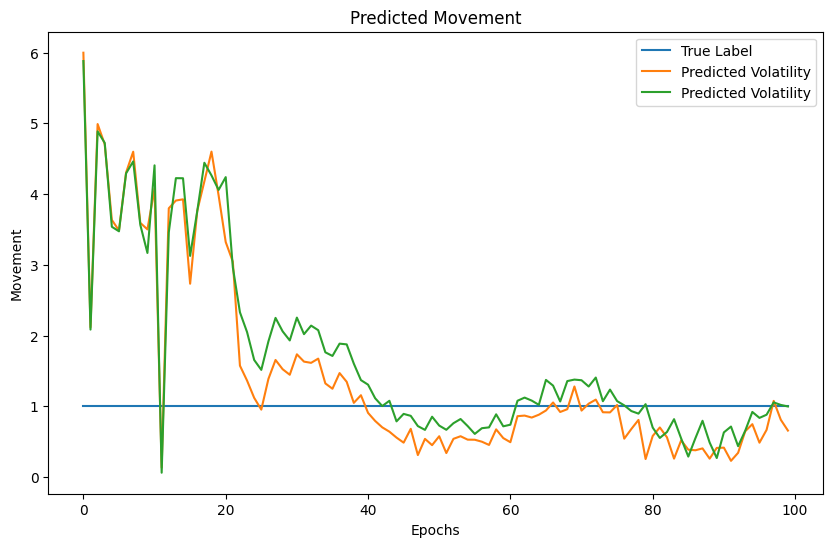

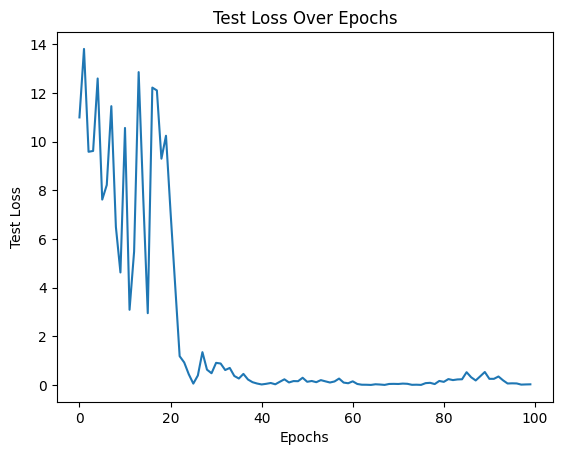

In [48]:
# Run the main function
if __name__ == "__main__":

    #print('OPTIONS ', options)
    # Tuning Parameters:
    import easydict
    from argparse import ArgumentParser
    parser = ArgumentParser()
    args = parser.parse_known_args()[0]
    #使用 easydict，可以创建一个命名空间对象，该对象具有字典的功能，并允许通过点号操作符来访问和设置键值对。
    args = easydict.EasyDict({
            "num_epochs": 100,
            "batch_size": 1,
            "lr": 0.0005,
            "tb_dir": "./runs",
            "final": False,
            "max_pool": False,
            "embedding_size" : 768,
            "vocab_size" : 50000,
            "max_length" : 520,
            "num_heads" : 2,
            "depth" : 2,
            "seed" : 1,
            "lr_warmup" : 500,
            "gradient_clipping" : 1.0
    })
    evaluation = go(args)

    epoch_numbers = evaluation['epoch']
    test_accuracies = evaluation['Test Accuracy']

    # 将数据转换为 NumPy 数组
    epoch_numbers = np.array(epoch_numbers)
    test_accuracies = np.array(test_accuracies)

    # 获取排序后的索引
    sorted_indices = np.argsort(epoch_numbers)

    # 根据排序后的索引获取排序后的数据
    sorted_epoch_numbers = epoch_numbers[sorted_indices]
    sorted_test_accuracies = test_accuracies[sorted_indices]

    # 绘制迭代MSE折线图
    plt.plot(sorted_epoch_numbers, sorted_test_accuracies)
    plt.xlabel('Epochs')
    plt.ylabel('Test Loss')  # 或者 'Test Accuracy'，具体根据你的情况来确定
    plt.title('Test Loss Over Epochs')
    plt.show()